20:44:14 - cmdstanpy - INFO - Chain [1] start processing
20:44:14 - cmdstanpy - INFO - Chain [1] done processing


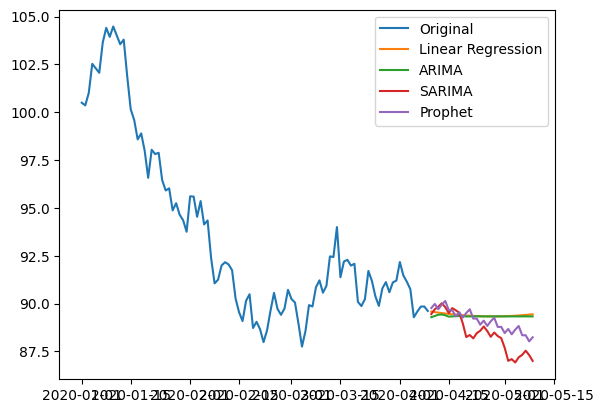

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet

# データの準備
np.random.seed(42)
date_range = pd.date_range(start='2020-01-01', periods=100, freq='D')
data = np.cumsum(np.random.randn(100)) + 100  # ランダムウォーク
df = pd.DataFrame({'ds': date_range, 'y': data})

# 線形回帰で1階差を予測
def linear_regression_forecast(df, future_steps):
    df['diff'] = df['y'].diff().fillna(0)
    df['day'] = np.arange(len(df))
    
    X = df[['day']]
    y = df['diff']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    
    model_lr = LinearRegression()
    model_lr.fit(X_train, y_train)
    
    # 予測値を累積して元のスケールに戻す
    y_pred_diff = model_lr.predict(X_test)
    y_pred = np.cumsum(y_pred_diff) + df['y'].iloc[len(X_train)-1]
    
    # 将来の予測
    future_preds = []
    last_value = df['y'].iloc[-1]
    
    for i in range(future_steps):
        # `next_day`に列名を付けてモデルに入力
        next_day = pd.DataFrame([[len(df) + i]], columns=['day'])
        next_diff = model_lr.predict(next_day)
        last_value += next_diff[0]
        future_preds.append(last_value)
    
    future_dates = pd.date_range(start=df['ds'].iloc[-1] + pd.Timedelta(days=1), periods=future_steps)
    
    return df['ds'].iloc[-len(y_pred):], y_pred, future_dates, future_preds

# ARIMAでの予測
def arima_forecast(df, future_steps):
    model_arima = ARIMA(df['y'], order=(5,1,0))
    arima_result = model_arima.fit()
    
    forecast_arima = arima_result.forecast(steps=future_steps)
    future_dates = pd.date_range(start=df['ds'].iloc[-1] + pd.Timedelta(days=1), periods=future_steps)
    
    return future_dates, forecast_arima

# SARIMAでの予測
def sarima_forecast(df, future_steps):
    sarima_model = SARIMAX(df['y'], order=(1,1,1), seasonal_order=(1,1,1,12))
    sarima_result = sarima_model.fit()
    
    forecast_sarima = sarima_result.get_forecast(steps=future_steps)
    future_dates = pd.date_range(start=df['ds'].iloc[-1] + pd.Timedelta(days=1), periods=future_steps)
    
    return future_dates, forecast_sarima.predicted_mean

# Prophetでの予測
def prophet_forecast(df, future_steps):
    model = Prophet()
    model.fit(df)
    
    future = model.make_future_dataframe(periods=future_steps)
    forecast = model.predict(future)
    
    return forecast['ds'].iloc[-future_steps:], forecast['yhat'].iloc[-future_steps:]

# 予測結果を可視化
def plot_forecasts(df, future_steps):
    # 元データのプロット
    plt.plot(df['ds'], df['y'], label='Original')
    
    # 線形回帰
    _, y_pred, future_dates_lr, future_preds_lr = linear_regression_forecast(df, future_steps)
    plt.plot(future_dates_lr, future_preds_lr, label='Linear Regression')
    
    # ARIMA
    future_dates_arima, forecast_arima = arima_forecast(df, future_steps)
    plt.plot(future_dates_arima, forecast_arima, label='ARIMA')
    
    # SARIMA
    future_dates_sarima, forecast_sarima = sarima_forecast(df, future_steps)
    plt.plot(future_dates_sarima, forecast_sarima, label='SARIMA')
    
    # Prophet
    future_dates_prophet, forecast_prophet = prophet_forecast(df, future_steps)
    plt.plot(future_dates_prophet, forecast_prophet, label='Prophet')
    
    plt.legend()
    plt.show()

# 将来予測を表示
future_steps = 30
plot_forecasts(df, future_steps)
